In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [229]:
import warnings
warnings.filterwarnings('ignore')

In [230]:
plt.style.use('seaborn-darkgrid')

In [231]:
def plot_scatter(x, y, auto_scaled=True, title=None,
                 clusters=None, TypeScaler=None,
                 Clustering=True, equal_scaled=False,
                 figsize_x = 4, figsize_y = 4):
    plt.figure(figsize=(figsize_x, figsize_y))
    
    if TypeScaler =='MinMaxScaler':
            #sklearn.preprocessing.MinMaxScaler
            scaler = MinMaxScaler()
            x = x.reshape(-1, 1)
            scaler.fit(x)
            x = scaler.transform(x)
            y = y.reshape(-1, 1)
            scaler.fit(y)
            y = scaler.transform(y)
    if TypeScaler =='StandardScaler':
            #sklearn.preprocessing.StandardScaler
            scaler = StandardScaler()
            x = x.reshape(-1, 1)
            scaler.fit(x)
            x = scaler.transform(x)
            y = y.reshape(-1, 1)
            scaler.fit(y)
            y = scaler.transform(y)
   
    
    if clusters == 'Kmeans':
        Kmean = KMeans(n_clusters=2)
        data = np.column_stack((x, y))
        Kmean.fit(data)
        x, y = data[:, 0], data[:, 1]
        clusters = Kmean.fit_predict(np.array([x, y]).T)
    
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
        
    if equal_scaled == True:   
        plt.xlim([-15, 15])
        plt.ylim([-5, 10])
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [232]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [233]:
# 1 point
def scale(X):
    result = pd.DataFrame()
    col_nam = X.columns
    for col in col_nam:
        mean = X[col].mean()
        std = X[col].std(ddof=0)
        result[col]  = X[col].apply(lambda x: (x - mean) / std)
    return result

In [234]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))
print('success')

success


### Pipeline Version (2 points)

In [235]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy, with_mean, with_std) 
        self.mean_ = None
        self.var_ = None

        
    def fit(self, X, y=None):
        self.scaler.fit(X[X.columns], y)
        self.mean_ = np.mean(X[X.columns]) 
        self.var_ = np.var(X[X.columns])
        return self
    
    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[X.columns]), columns=X.columns)
        X_not_scaled = X.loc[:,~X.columns.isin(X.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [236]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))
print('success')

success


## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [237]:
feature_0 = np.random.randn(1000) * 10
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-10.1106121 ,  -1.27634441],
       [  4.15951258,  -1.42402987],
       [ -1.11458576,   0.63065605],
       ...,
       [ 13.81110753,   6.44430441],
       [ 10.59273664,   3.26955844],
       [ -0.82752065,   5.79710432]])

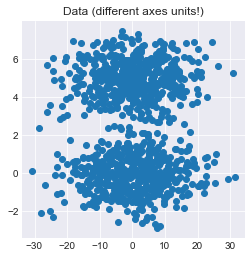

In [238]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

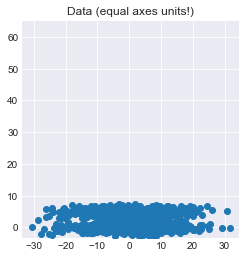

In [239]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

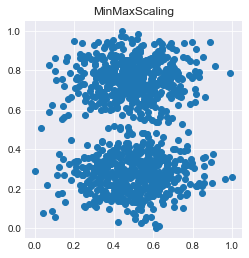

In [240]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='MinMaxScaling', TypeScaler='MinMaxScaler')

### StandardScaler (0.5 point)

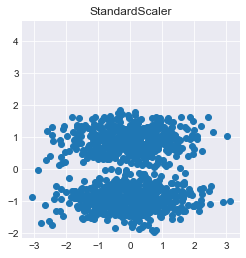

In [241]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='StandardScaler', TypeScaler='StandardScaler')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [242]:
from sklearn.cluster import KMeans

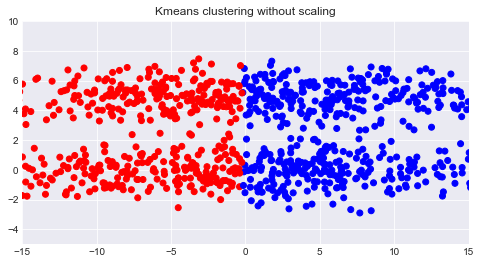

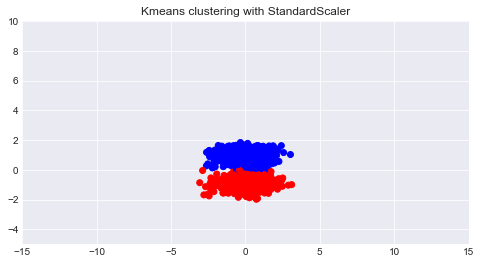

In [243]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False,
             clusters ='Kmeans', title='Kmeans clustering without scaling',
             TypeScaler=None, equal_scaled=True,
             figsize_x =8, figsize_y=8)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False,
             clusters ='Kmeans', title='Kmeans clustering with StandardScaler',
             TypeScaler='StandardScaler', equal_scaled=True,
             figsize_x =8, figsize_y=8)


Как видим масштабирование сыграло очевидно важную роль в кластеризации алгоритмом Kmeans: неотмасштабированные данные кластеризовались неправильно.

## Exercise  3 - Preprocessing Pipeline (2 points)

In [244]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [245]:
from sklearn.metrics import f1_score
def make_model(regressor,scaler=None,feature_selector=None):
    if scaler=="MinMaxScaler":
        if feature_selector=="SelectFromModel":
            clf = LogisticRegression(random_state=42, solver='liblinear', penalty='l1')
            return Pipeline([
                ('sca', MinMaxScaler()),
                ('sel', SelectFromModel(clf)),
                ('reg', regressor)])
        else:
            return Pipeline([
                ('sca', MinMaxScaler()),
                ('reg', regressor)])
    elif scaler=="StandardScaler":
        if feature_selector=="SelectFromModel":
            clf = LogisticRegression(random_state=42, solver='liblinear', penalty='l1')
            return Pipeline([
                ('sca', StandardScaler()),
                ('sel', SelectFromModel(clf)),
                ('reg', regressor)])
        else:
            return Pipeline([
                ('sca', StandardScaler()),
                ('reg', regressor)])
    else:
        return Pipeline([
            ('reg', regressor)])
    
regressor = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, random_state=42)

# 1 No scaling and features selection
model1 = make_model(regressor).fit(wine_train, wine_labels_train)
acc = accuracy_score(wine_labels_val, model.predict(wine_val))
f1 = f1_score(wine_labels_val, model.predict(wine_val),average='macro')
print('Показатели модели без масштабирования и отбора метрик : \naccuracy: ',acc, ", f1 score: ",f1, sep='', end='\n\n')

# 2 With scaling and without features selection
model2 = make_model(regressor,"StandardScaler").fit(wine_train, wine_labels_train)
#print('Count zero coef.=',np.count_nonzero(np.abs(model['reg'].coef_ == 0)))
acc = accuracy_score(wine_labels_val, model2.predict(wine_val))
f1 = f1_score(wine_labels_val, model2.predict(wine_val),average='macro')
print('Показатели модели c масштабированием, но без отбора метрик : \naccuracy: ',
      acc, ", f1 score: ",f1, sep='', end='\n\n')

# 3 With scaling and features selection
model3 = make_model(regressor, 'StandardScaler', 'SelectFromModel').fit(wine_train, wine_labels_train)
acc = accuracy_score(wine_labels_val, model3.predict(wine_val))
f1 = f1_score(wine_labels_val, model3.predict(wine_val),average='weighted')
print('Показатели модели c масштабированием и с отбором метрик : \naccuracy: ',
      acc, ", f1 score: ",f1, sep='', end='\n\n')

# 4 Without scaling and with features selection
model4 = make_model(regressor,'SelectFromModel').fit(wine_train, wine_labels_train)
acc = accuracy_score(wine_labels_val, model4.predict(wine_val))
f1 = f1_score(wine_labels_val, model4.predict(wine_val),average='weighted')
print('Показатели модели без масштабирования, но с отбором метрик : \naccuracy: ',
      acc, ", f1 score: ",f1, sep='', end='\n\n')

Показатели модели без масштабирования и отбора метрик : 
accuracy: 0.7592592592592593, f1 score: 0.7659092446067491

Показатели модели c масштабированием, но без отбора метрик : 
accuracy: 1.0, f1 score: 1.0

Показатели модели c масштабированием и с отбором метрик : 
accuracy: 1.0, f1 score: 1.0

Показатели модели без масштабирования, но с отбором метрик : 
accuracy: 0.9629629629629629, f1 score: 0.9629629629629629



Как видим, масштабирование значительно улучшило качество предсказание модели, что нельзя точно сказать про отбор метрик, так как после отбора метрик скор уже максимальный и улучшать его некуда, поэтому я добавил ещё 1 пайплайн без мастабирования, но с отбором метрик и уже можно нагляжно увидеть, что отбор метрик также сильно влияет на качество предсказания модели.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [246]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [247]:
wine_data_std = StandardScaler().fit_transform(wine_data)
pca = PCA(n_components=wine_data.shape[1])
pca.fit_transform(wine_data)
wine_data_std = StandardScaler().fit_transform(wine_data)
S =((wine_data_std-np.mean(wine_data_std,axis=0)).T @ (wine_data_std-np.mean(wine_data_std,axis=0)))/(wine_data_std.shape[0]-1)

If your code is correct, the following assert should be Ok.

In [248]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)
print('success')

success


In [249]:
from scipy.optimize import minimize

def objective(x):
    return -1*(x.T @ S @ x)
def norm_constraint(x):
    
    return 1 - np.linalg.norm(x)
con1 = {'type': 'eq', 'fun': norm_constraint}
x0 = wine_data_std[0,:]
result = minimize(objective, x0, constraints = [con1])
x0 = result.x

Hurray! We have first vector! Let's do another one.

In [250]:
def orthogonality_constraint(x):
    c2 = x @ x0
    return c2

con2 = {'type': 'eq', 'fun': orthogonality_constraint}
x1 = wine_data_std[0,:]
result = minimize(objective, x1, constraints = [con2,con1])
x1 = result.x

In [251]:
pca = PCA(n_components=2)
wine_data_scaled_pca = pca.fit_transform(wine_data_std)

If your solution is correct, the following asserts should be Ok.

In [252]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)
print('success')

success


### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

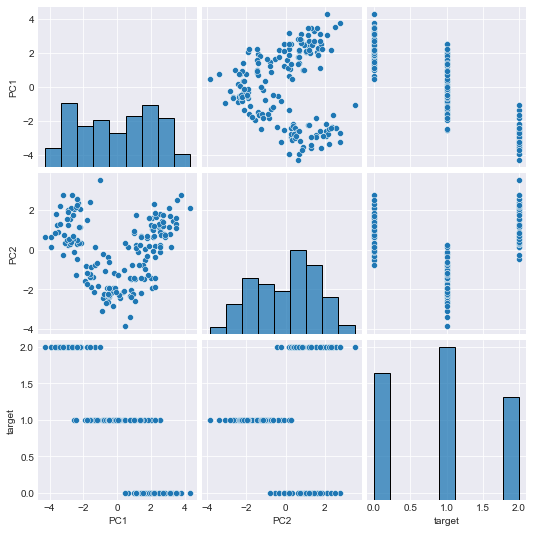

In [253]:
x0_x1 = np.concatenate((x0, x1), axis=0).reshape(2,13)
data = (x0_x1 @ wine_data_std.T).T
data_df = pd.DataFrame(data=data,columns=["PC1","PC2"])
sns_plot = sns.pairplot(pd.concat([data_df,wine_labels],axis=1))

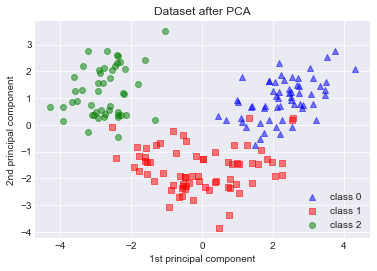

In [254]:
fig, ax = plt.subplots()
for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax.scatter(data_df[wine_labels == l].iloc[:,0], data_df[wine_labels == l].iloc[:,1], 
                color=c, label=f'class {l}', alpha=0.5, marker=m)
    
ax.set_title('Dataset after PCA')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.legend(loc='lower right')
plt.show()

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [255]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

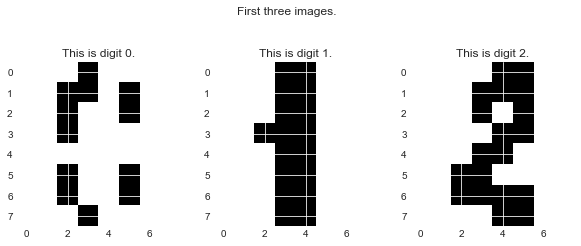

In [256]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [257]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42)

In [258]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169
print('success')

success


Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [259]:
clf = RandomForestClassifier(max_depth=13)
clf.fit(X_train, y_train)
acc = clf.score(X_val, y_val)
print(acc)

0.9876543209876543


In [260]:
assert acc > 0.98
print('success')

success


Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [261]:
! pip install boruta

In [262]:
%%time
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)
feat_selector.fit(X_train.values, y_train.values)

Wall time: 18.3 s


BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x1FAD7D32840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1FAD7D32840)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

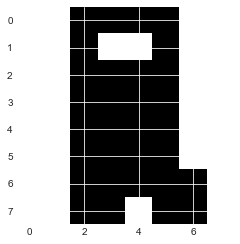

In [263]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

Похож =)

At the end let us redo  classification but only with selected features

In [264]:
clf = RandomForestClassifier(max_depth=13)
X_train_clear = feat_selector.transform(X_train.values)
X_val_clear = feat_selector.transform(X_val.values)
clf.fit(X_train_clear, y_train)
acc = clf.score(X_val_clear, y_val)
print(acc)

0.9938271604938271


In [265]:
assert acc > 0.99
print('success')

success


# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market